In [1]:
import numpy as np
import pandas as pd

import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull
import tqdm
from statsmodels.nonparametric.smoothers_lowess import lowess

# Delaunay triangulation
from scipy.spatial import Delaunay


In [2]:
# extract the RMS RMSD from the above file
def extractRMSRMSD(filename):
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith("[M::__main__] RMS RMSD"):
                    return float(line.split()[3])
    except:
        print(f"Warning: {filename} does not exist.")
        return None

In [3]:
rmsd_new = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/structure/reRun_3D/stat/rmsd.csv", index_col = 0)
rmsd_new = rmsd_new.query('`20k` < 1.5')

In [4]:
pass_cellnames = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/stat/stat_all_1025.csv").query("`20k` < 1.5")["cellname"].values
metadata_structral_qc = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/s1014_metadata_X_noM_noXistneg.csv").query("cellname in @pass_cellnames")

In [5]:
len(pass_cellnames)

289

In [6]:
cellnames_structral_qc = metadata_structral_qc["cellname"].values

In [7]:
len(cellnames_structral_qc)

238

# Alpha shape

In [8]:
import alphashape

In [9]:
cellname = "d3A2"
tdg = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/structure/reRun_3D/processed/{cellname}/3d_info/clean.200k.0.3dg".format(cellname=cellname),sep="\t",header=None)
tdg.columns = ["chrom","pos","x","y","z"]

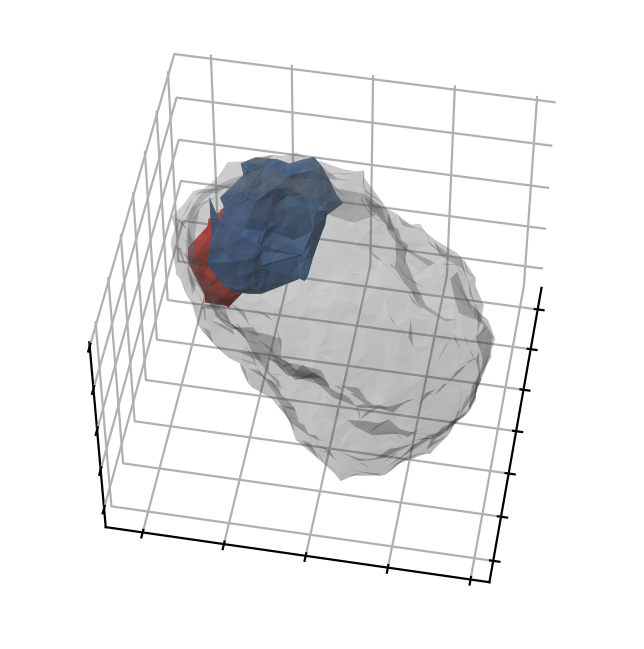

In [10]:
# 假设这两组points是你从tdg.query()获取的数据
points1 = tdg.query("chrom == 'chrX(mat)'")[["x", "y", "z"]].values
points2 = tdg.query("chrom == 'chrX(pat)'")[["x", "y", "z"]].values
points = tdg[["x","y","z"]].values

alpha = 0.4  # 你可以根据需要设置Alpha值

fig = plt.figure(figsize=(4, 4), dpi=200)
ax = fig.add_subplot(111, projection='3d')

# 画第一组点和对应的Alpha shape
# ax.scatter(points1[:, 0], points1[:, 1], points1[:, 2], c='#b2182b', marker='o', alpha=0.6, s = 0.5)
alpha_shape1 = alphashape.alphashape(points1, alpha)
ax.plot_trisurf(*zip(*alpha_shape1.vertices), triangles=alpha_shape1.faces, color='#d73027', alpha=0.8)

# 画第二组点和对应的Alpha shape
# ax.scatter(points2[:, 0], points2[:, 1], points2[:, 2], c='#9ecae1', marker='o', alpha=0.6, s = 0.5)
alpha_shape2 = alphashape.alphashape(points2, alpha)
ax.plot_trisurf(*zip(*alpha_shape2.vertices), triangles=alpha_shape2.faces, color='#4575b4', alpha=0.8)

alpha_shape3 = alphashape.alphashape(points, alpha)
ax.plot_trisurf(*zip(*alpha_shape3.vertices), triangles=alpha_shape3.faces, color='gray', alpha=0.2)

ax.view_init(elev=50, azim=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
ax.grid(False)
ax.grid(True)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
# ax.set_axis_off()
plt.show()

In [11]:
def calculate_volume_cell(cellname, alpha=0.4):
    tdg = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0312_tidyup/structure/reRun_3D/processed/{cellname}/3d_info/clean.200k.0.3dg".format(cellname=cellname), sep="\t", header=None)
    tdg.columns = ["chrom", "pos", "x", "y", "z"]

    points = tdg.query("chrom == 'chrX(mat)'")[["x", "y", "z"]].values
    alpha_shape = alphashape.alphashape(points, alpha)
    mat_alpha_volume = alpha_shape.volume

    points = tdg.query("chrom == 'chrX(pat)'")[["x", "y", "z"]].values
    alpha_shape = alphashape.alphashape(points, alpha)
    pat_alpha_volume = alpha_shape.volume

    return {"cellname": cellname, "mat_alpha_volume": mat_alpha_volume, "pat_alpha_volume": pat_alpha_volume}

from multiprocessing import Pool
with Pool(processes=10) as pool:  
    volumes = list(tqdm.tqdm(pool.imap(calculate_volume_cell, cellnames_structral_qc), total=len(cellnames_structral_qc)))

100%|██████████| 238/238 [00:21<00:00, 11.15it/s]


In [12]:
plotdata = pd.merge(metadata_structral_qc, pd.DataFrame(volumes), on="cellname")

In [13]:
plotdata

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,sample2,sample3,cellcycle_threshold,day,nCount_SCT,nFeature_SCT,SCT_snn_res.1.5,seurat_clusters,plot_cluster,SCT_snn_res.1,pseudotime_monocle3,curve1,curve2,cellname,mat_alpha_volume,pat_alpha_volume
0,d0A1,SeuratProject,565,206,s1207,others,Mid-S,d0,473,191,2,3,0,3,0.013315,5.446870,5.445442,d0A1,450.237438,422.950972
1,d0A14,SeuratProject,785,242,s1207,others,Late-S,d0,491,226,2,3,0,3,0.007760,3.347443,3.351197,d0A14,340.887008,316.511840
2,d0A16,SeuratProject,674,231,s1207,others,G1,d0,463,213,2,3,0,3,0.036273,4.768241,4.768201,d0A16,426.800757,358.807819
3,d0A17,SeuratProject,707,238,s1207,others,G2,d0,476,221,2,3,0,3,0.000000,6.422934,6.414727,d0A17,430.396389,521.886020
4,d0A2,SeuratProject,429,169,s1207,others,Mid-S,d0,434,162,2,3,0,3,0.000295,10.121546,10.171596,d0A2,625.802794,580.386843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,d4C83,SeuratProject,545,177,s0728,others,Late-S,d4,473,168,3,2,5,2,14.393851,36.284984,NaN,d4C83,544.670380,426.134784
234,d4C91,SeuratProject,591,163,s0728,others,Late-S,d4,474,159,3,2,5,2,15.728901,43.241151,NaN,d4C91,640.409217,366.358734
235,d4C97,SeuratProject,600,161,s0728,others,G2,d4,472,146,4,4,3,4,11.005328,NaN,37.432851,d4C97,280.458542,396.626115
236,d15D16,SeuratProject,659,232,s1014,others,Late-S,d15,474,220,1,1,2,1,6.403063,21.011617,22.440988,d15D16,473.947991,441.036912


In [24]:
plotdata.to_csv("volume_alpha04.csv")

In [23]:
plotdata["diff"] = plotdata["pat_alpha_volume"] - plotdata["mat_alpha_volume"]